# Import Libaray

In [213]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from tqdm import tqdm
import missingno as msno
import warnings

# Settings

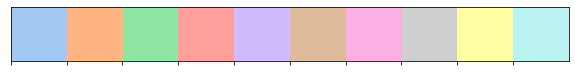

In [211]:
# warning ignore
warnings.filterwarnings('ignore')

data_path = '../input/data'

# 팔레트를 변수로 저장하고
qualitative_colors = sns.color_palette("Set3", 10)
sequential_colors = sns.color_palette("RdPu", 10)
sequential_colors9 = sns.color_palette("RdPu", 9)
diverging_colors = sns.color_palette("RdBu", 10)
palette = sns.color_palette("pastel")
# palplot을 통해 저장한 팔레트를 불러온다.
sns.palplot(palette)

# Data Load

In [7]:
train = pd.read_csv(os.path.join(data_path, 'train_data.csv'))
test = pd.read_csv(os.path.join(data_path, 'test_data.csv'))

In [8]:
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225


In [9]:
test.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623


# EDA

1. Basic EDA - 가장 기본적인 데이터를 분석합니다. 
    - train의 user, assessment, test, tag 분석
    - train의 데이터 통계
2. Detail EDA - 데이터를 미시적 관점으로 분석합니다.

In [10]:
train_user = train["userID"].unique()
test_user = test["userID"].unique()

print(f"훈련 데이터 유저 수 : {len(train_user)}")
print(f"테스트 데이터 유저 수 : {len(test_user)}")
print(f"훈련 데이터와 테스트 데이터의 겹치는 유저 비율 {len(set(train_user).intersection(set(test_user)))/len(train_user)}")

훈련 데이터 유저 수 : 6698
테스트 데이터 유저 수 : 744
훈련 데이터와 테스트 데이터의 겹치는 유저 비율 0.0


전체 유저의 10% 정도가 테스트로 분류되었고 훈련 데이터와 테스트 데이터의 유저 정보는 겹치지 않는 것으로 보입니다.

In [379]:
train_assess = train["assessmentItemID"].unique()
test_assess = test["assessmentItemID"].unique()

print(f"훈련 데이터의 문항 종류 : {len(train_assess)}")
print(f"테스트 데이터의 문항 종류 : {len(test_assess)}")
print(f"훈련 데이터와 테스트 데이터의 겹치는 문항 비율 {len(set(train_assess).intersection(set(test_assess)))/len(train_assess)}")

훈련 데이터의 문항 종류 : 9454
테스트 데이터의 문항 종류 : 9454
훈련 데이터와 테스트 데이터의 겹치는 문항 비율 1.0


In [18]:
train_test = train["testId"].unique()
test_test = test["testId"].unique()

print(f"훈련 데이터의 시험지 종류 : {len(train_test)}")
print(f"테스트 데이터의 시험지 종류 : {len(test_test)}")
print(f"훈련 데이터와 테스트 데이터의 겹치는 시험지 비율 {len(set(train_test).intersection(set(test_test)))/len(train_test)}")

훈련 데이터의 시험지 종류 : 1537
테스트 데이터의 시험지 종류 : 1537
훈련 데이터와 테스트 데이터의 겹치는 시험지 비율 1.0


In [20]:
train_tag = train["KnowledgeTag"].unique()
test_tag = test["KnowledgeTag"].unique()

print(f"훈련 데이터의 태그 종류 : {len(train_tag)}")
print(f"테스트 데이터의 태그 종류 : {len(test_tag)}")
print(f"훈련 데이터와 테스트 데이터의 겹치는 태그 비율 {len(set(train_tag).intersection(set(test_tag)))/len(train_tag)}")

훈련 데이터의 태그 종류 : 912
테스트 데이터의 태그 종류 : 912
훈련 데이터와 테스트 데이터의 겹치는 태그 비율 1.0


`Timestamp`, `answerCode`를 제외한 모든 feature를 분석한 결과 user를 제외한 모든 feature는 train과 test에 동일하게 들어가 있음을 알 수 있습니다.  
대회의 데이터 소개에 따르면 전반적인 시험지의 구조는 아래와 같습니다.

![](./img/test_architecture.png)

문항들과 관련된 데이터를 분석할 때 크게 대분류인 시험지별, 중분류인 문제 태그별, 소분류인 문제별로 통계치를 분석하는 것이 좋을 것으로 보입니다.  
여기서 고려할만한 것은 대략적으로 다음과 같습니다.
- Test간의 난이도를 줄 세울 수 있을 것인가?
    - 쉬운 시험부터 어려운 시험까지 어느정도 줄을 세울 수 있다면 충분히 정답 예측에 도움을 줄 수 있을 것 입니다.
- Test내부의 문항 종류(Knowledge Tag)의 분포를 알아볼 필요도 있습니다.
- KnowledgeTag 간의 연관성을 볼 가치가 있습니다.
    - 단순히 KnowledgeTag를 LabelEncoder 방식으로 표현해서 상관관계를 보면 수치에 의미가 부여될 수 있습니다.
    - 이를 해결하고자 각 시험별로 혹은 태그별로 정답률을 기록한 데이터프레임을 제작해서 상관관계를 보면 수치분석이 가능할 것으로 보입니다.
- 아주 단순한 것은 문항별로 정답률을 분석해보는 것입니다.
- 문항은 세밀한 값으로 분리되어 있어서 단독으로 데이터를 보는 것이 얼마나 의미가 있을지 확신이 없기는 합니다.
    - 이에 대해서는 EDA를 진행하면서 추가적인 아이디어가 나타날 것으로 보입니다.

## testId 분석

우선적으로 대분류로 활용되는 `testId`를 분석하겠습니다.  
`testId`의 구조는 다음과 같습니다.  

![](./img/tesId.png)  

기본적으로 첫 A와 중간부 000 세자리는 공통적으로 의미가 없는 상태입니다.  
1 \~ 3인덱스의 내용은 010 \~ 090까지로 가장 큰 대분류가 가능합니다.  
이때 `testId`의 마지막 3자리가 1 \~ 3인덱스의 세부분류가 됩니다.  
만약 마지막 3자리가 의미가 충분했다면 굳기 010 \~ 090으로 데이터를 먼저 분류할 필요는 없었을 것으로 보입니다.  

이에 010~090을 **난이도, KnowledgeTag비율**과 같은 다른 지표로 분류가 되는지 확인할 필요가 있습니다.

### train data 전처리

In [73]:
# Make testId Large categories and Middle categories
train["test_L"] = train["testId"].apply(lambda x: int(x[2]))
train["test_M"] = train["testId"].apply(lambda x: int(x[-3:]))
# Make data counts
train["counts"] = 1

In [75]:
train_L_group = train.groupby("test_L").sum().reset_index()
train_LKT_group = train.groupby(["test_L", "KnowledgeTag"]).sum().reset_index()

In [76]:
train_L_group["answer_rate"] = train_L_group["answerCode"]/test_L_group["counts"]

In [77]:
train_L_group[["test_L", "answer_rate"]]

,test_L,answer_rate
0,1,0.800876
1,2,0.737593
2,3,0.702238
3,4,0.684056
4,5,0.658208
5,6,0.709232
6,7,0.521876
7,8,0.502598
8,9,0.449948


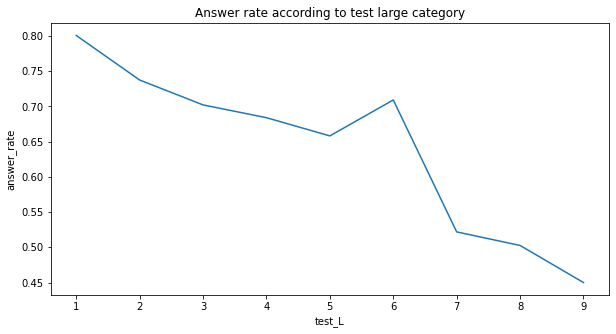

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(data=train_L_group, x="test_L", y="answer_rate", ax=ax)
ax.set_title("Answer rate according to test large category")
plt.show()

편의상 010 \~ 090을 대분류라고 하겠습니다.  
대분류를 유저들의 정답률로 확인해보면 대분류의 숫자가 커질수록 정답률이 떨어지는 것을 볼 수 있습니다.  
물론 중간 6번 문항에서 정답률이 올라가기는 하지만 충분히 상관성이 존재하는 것으로 보입니다.  
이를 토대로 대분류는 **난이도**라고 이름을 붙이기에 충분할 것으로 보입니다.

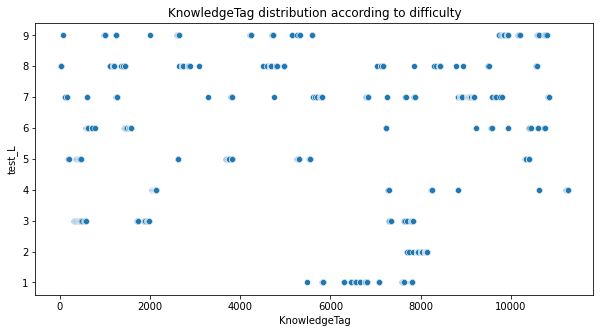

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.scatterplot(data=train_LKT_group, x="KnowledgeTag", y="test_L", ax=ax)
ax.set_title("KnowledgeTag distribution according to difficulty")
plt.show()

`KnowledgeTag`의 분포가 난이도와 큰 연관성을 보이는 느낌은 없습니다. 낮은 난이도는 어느정도 군집을 이루는 것으로 보입니다.  
하지만 난이도가 높아질수록 군집을 이루는 경향이 줄어듭니다.  

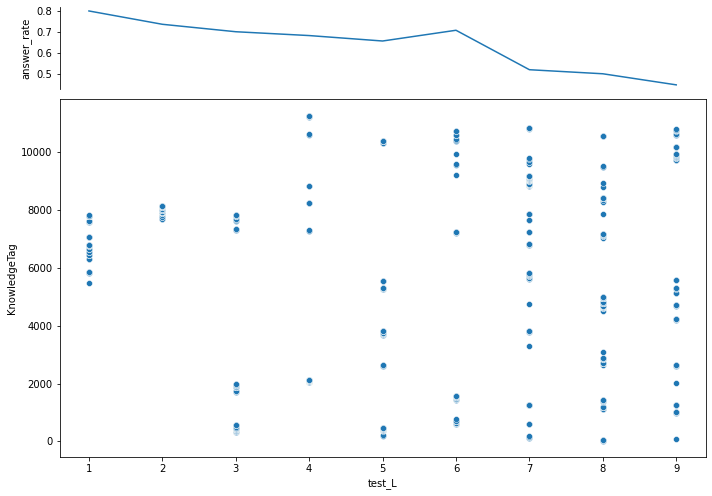

In [151]:
fig = plt.figure(figsize=(10, 7))
axes = [None for _ in range(2)]

axes[0] = plt.subplot2grid((5, 4), (1, 0), colspan=4, rowspan=4)
axes[1] = plt.subplot2grid((5, 4), (0, 0), colspan=4)

sns.scatterplot(data=train_LKT_group, x="test_L", y="KnowledgeTag", ax=axes[0])
sns.lineplot(data=train_L_group, x="test_L", y="answer_rate", ax=axes[1])

axes[1].spines["bottom"].set_visible(False)
axes[1].spines["right"].set_visible(False)
axes[1].spines["top"].set_visible(False)
axes[1].set_xticks([])
axes[1].set_xlabel("")

plt.tight_layout()
plt.show()

여기서 특이한 점은 군집을 이루는 난이도들은 정답률이 올라가는 경향이 있는 것으로 보입니다.  
오히려 살짝 틀어서 생각해 볼 수도 있을 것 같습니다.  
군집을 이루고 있는 정도와 난이도를 알아볼 수 있을 것으로 보입니다.

In [384]:
train_m_group = train.groupby("test_M").sum().reset_index()

In [385]:
train_m_group["answer_rate"] = train_m_group["answerCode"]/train_m_group["counts"]

In [396]:
train_ml_group = train.groupby(["test_M", "test_L"]).sum().reset_index()
train_ml_group["answer_rate"] = train_ml_group["answerCode"]/train_ml_group["counts"]

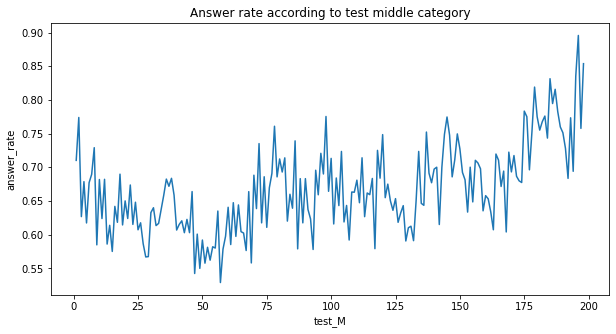

In [389]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(data=train_m_group, x="test_M", y="answer_rate", ax=ax)
ax.set_title("Answer rate according to test middle category")
plt.show()

시험지의 중분류'만' 보는 경우는 사실 큰 의미가 없을 것이라 생각했는데 역시나 큰 의미는 없습니다.

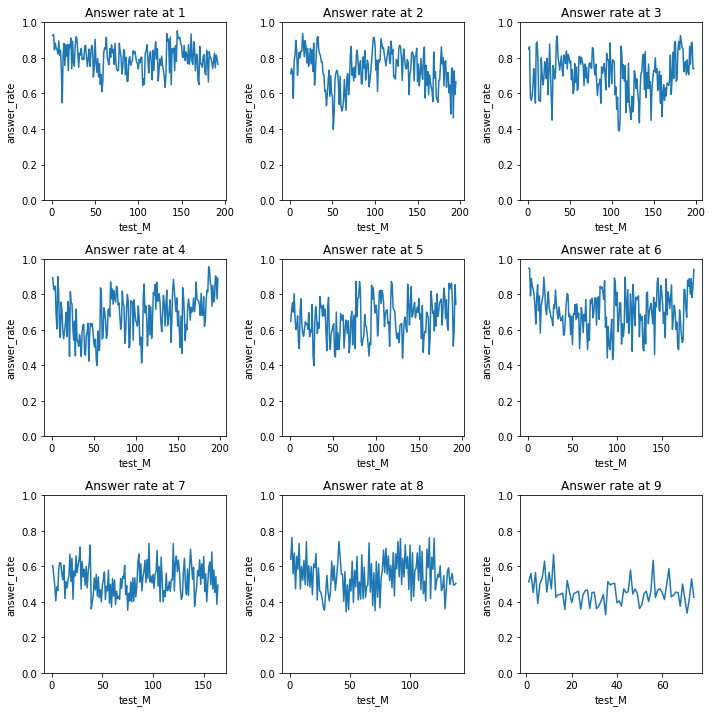

In [399]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for idx, ax in enumerate(axes.flatten()):
    tmp = train_ml_group[train_ml_group["test_L"] == idx+1]
    sns.lineplot(data=tmp, x="test_M", y="answer_rate", ax=ax)
    ax.set_ylim([0.0, 1.0])
    ax.set_title(f"Answer rate at {idx+1}")
    
plt.tight_layout()
plt.show()

그렇다면 이번에는 난이도별로 분류를 했습니다.  
그렇다고해도 문제번호가 뒤로갈수록 정답률에 영향을 미치는 것 같지는 않습니다.

## KnowledgeTag 분석

이번에는 `KnowledgeTag`를 분석해보겠습니다.  
`KnowledgeTag`는 문항당 배정되는 일종의 문제 종류입니다.  
실제로 대회 데이터 설명에서도 군집화에 활용할 수 있다고 했습니다.  
`KnowledgeTag`간의 연관성을 살펴보고 어느정도 규칙성과 군집화 기준을 설정해보겠습니다.

In [281]:
train_ukt_group = train.groupby(["userID", "KnowledgeTag"]).sum()
train_ukt_group["answer_rate"] = train_ukt_group["answerCode"]/train_ukt_group["counts"]

In [282]:
tkg = train_ukt_group.reset_index()

In [283]:
user_kt_table = tkg.pivot_table(index="userID", columns="KnowledgeTag", values="answer_rate").fillna(0.0)

In [301]:
kt_corr = user_kt_table.corr()

In [303]:
mask = (kt_corr<0.5).values
mask[np.triu_indices_from(mask)] = True

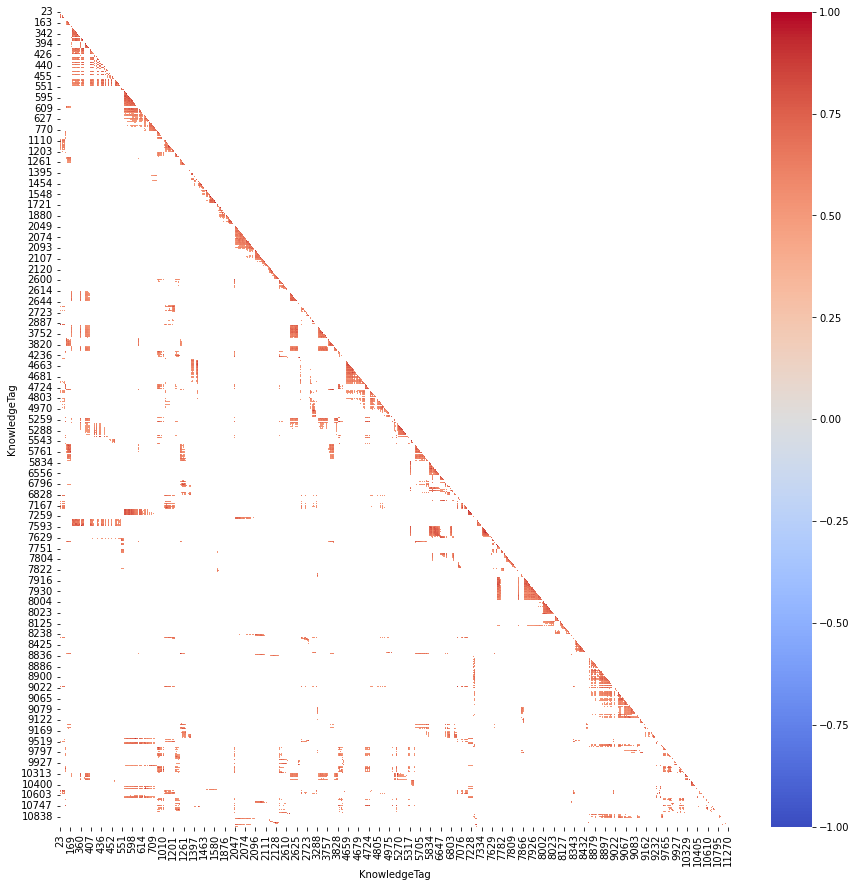

In [304]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sns.heatmap(kt_corr, vmin=-1, vmax=1, mask=mask, cmap="coolwarm")
plt.show()

사용자별 `KnowledgeTag`에 대한 정답률을 기록하고 이를 토대로 `KnowledgeTag`간에 정답률의 상관관계가 있는지 알아보고자 heatmap을 그렸습니다.  
feature가 912개라 정확히 어떤 태그끼리 연관성을 보이는지 알기는 어렵지만 correlation이 0.5이상인 경우에 대해 표시해보면 상관관계가 강한 태그 조합이 있는 것을 알 수 있습니다.

## assessmentID 분석

일반적으로 시험은 뒤로 갈수록 어려운 문제가 많이 나타납니다.  
그렇다면 시험지에 대해서 `assessmentID`의 마지막 3자리의 숫자에 따라 정답률의 영향을 어느정도 미칠 수 있을 것입니다.  
이를 알아보도록 하겠습니다.

In [306]:
train["test_S"] = train["assessmentItemID"].apply(lambda x: int(x[-3:]))

In [310]:
train["test_S"].unique()

array([ 1,  2,  3,  4,  5,  7,  6,  8,  9, 10, 11, 12, 13])

시험지 1개에 최대 13개의 문항까지 존재하는 것을 알 수 있습니다. 이를 토대로 생각해볼 것은 몇가지가 있습니다.  

- 문제 개수가 시험지의 정답률에 영향을 미칠까?
- 문제 번호가 뒤로갈수록 정답률에 영향을 미칠까?

이 2가지를 관점으로 알아보겠습니다.

In [318]:
train_s_group = train.groupby("test_S").sum().reset_index()
train_s_group["answer_rate"] = train_s_group["answerCode"]/train_s_group["counts"]

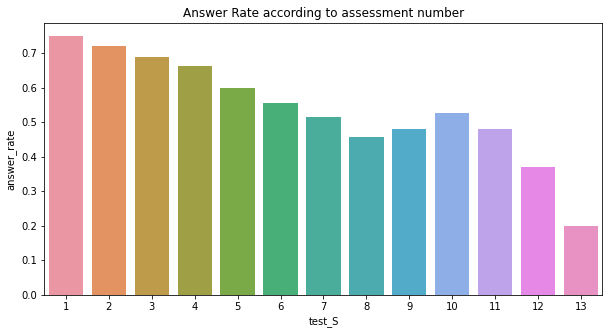

In [320]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.barplot(data=train_s_group, x="test_S", y="answer_rate", ax=ax)
ax.set_title("Answer Rate according to assessment number")
plt.show()

문항의 번호가 올라갈수록 전반적인 정답률이 낮아지는 것을 알 수 있습니다. 물론 문항의 개수차이로 이런 문제가 발생했을 가능성도 있습니다.  
그렇다고 해도 어느정도 감소가 있는 것을 알 수 있습니다.

In [362]:
tmp = train.groupby("testId").sum()
answer_rate = (tmp["answerCode"]/tmp["counts"])

In [364]:
tmp = train.drop_duplicates(["assessmentItemID"])

In [365]:
test_nums = tmp.groupby("testId").sum()
test_nums["answer_rate"] = answer_rate

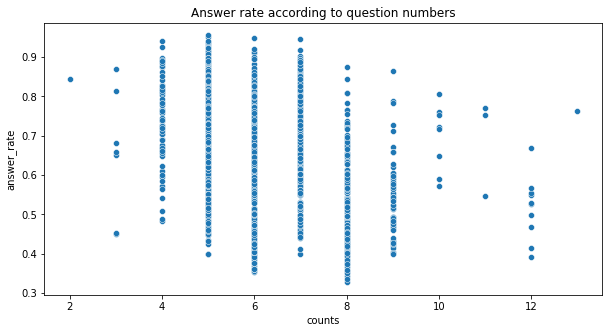

In [377]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.scatterplot(data=test_nums, x="counts", y="answer_rate", ax=ax)
ax.set_title("Answer rate according to question numbers")
plt.show()

문제의 개수가 정답률에 큰 영향을 미치는 것으로 보이지는 않습니다.

## userID 분석

이번에는 `userID`와 관련된 분석을 하겠습니다.  
`userID` 자체를 분석한다기보다는 유저별로 분류해서 특징을 잡아내는 분석을 할 것입니다.  
가장 우선적으로 떠오르는 것은 시험이라는 특성상 유저의 등수를 매길 수 있는 것인가 입니다.

In [410]:
train_u_group = train.groupby("userID").sum()
train_u_group["answer_rate"] = train_u_group["answerCode"]/train_u_group["counts"]
train_uc_group = train_u_group.groupby("counts").mean()

In [420]:
rank = [i for i in range(1, len(train_u_group)+1)]
train_u_group = train_u_group.sort_values("answer_rate", ascending=False)
train_u_group["rank"] = rank
train_u_group = train_u_group.sort_values("userID")

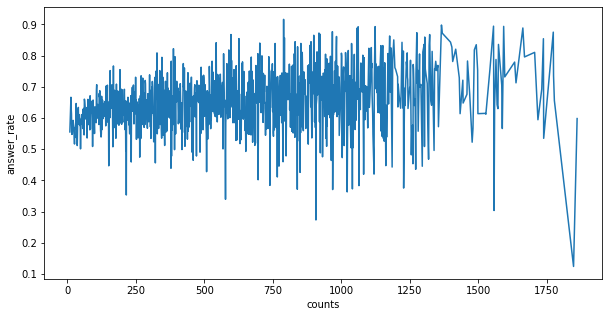

In [411]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(data=train_uc_group, x="counts", y="answer_rate", ax=ax)
plt.show()

문제를 푼 개수가 많을수록 정답률이 떨어질 확률이 높을 것이라 생각했으나 생각보다 경향이 나타나지는 않습니다.

In [422]:
train_u_group["inv_rank"] = 1/train_u_group["rank"]

In [424]:
train_uc_group = train_u_group.groupby("counts").mean()

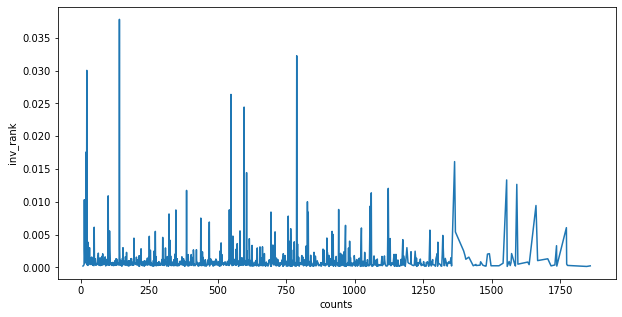

In [426]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(data=train_uc_group, x="counts", y="inv_rank", ax=ax)
plt.show()

문제를 푼 개수롸 등수와의 상관성도 크게 높게 나타나지는 않는 것으로 보입니다.

In [427]:
train

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,test_L,test_M,counts,test_S
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,1,1,1
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,1,1,2
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,1,1,3
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,1,1,4
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,1,1,5
...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,3,71,1,5
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,4,165,1,1
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,4,165,1,2
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,4,165,1,3
